In [1]:
import numpy as np
import seaborn as sns
import torch
import torch.utils.data as data
from torch import nn, optim
from torch.nn import functional as F
import umap
import matplotlib.pyplot as plt
from pyHGT.model import GNN, GNN_from_raw
import scanpy as sp
import pandas as pd
import networkx as nx
from community import community_louvain
from torch_geometric.utils import k_hop_subgraph,to_networkx,from_networkx
from tqdm import tqdm
from collections import defaultdict
import matplotlib

In [2]:
adata=sp.read_h5ad("/users/PCON0022/haocheng/Basu_lab/rmarkdown/SCB01S5.h5ad")
adata

AnnData object with n_obs × n_vars = 10558 × 22905
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.ribo', 'percent.mito', 'feature.mad.higher', 'ribo.mad.higher', 'integrated_snn_res.0.1', 'seurat_clusters', 'X', 'ann_level_1_pred', 'ann_level_1_uncertainty', 'ann_level_2_pred', 'ann_level_2_uncertainty', 'ann_level_3_pred', 'ann_level_3_uncertainty', 'ann_level_4_pred', 'ann_level_4_uncertainty', 'ann_level_5_pred', 'ann_level_5_uncertainty', 'ann_finest_level_pred', 'ann_finest_level_uncertainty'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'

In [3]:
# adata.obs['ann_level_3_pred'].value_counts().plot(kind='barh')

In [4]:
celltype_names=list(adata.obs['ann_level_3_pred'].value_counts().index)
print("celltype names:",celltype_names)
cell_cluster_indexs=[]
indexs=np.arange(adata.shape[0])
for celltype_name in celltype_names:
    cell_cluster_indexs.append(indexs[adata.obs['ann_level_3_pred']==celltype_name])
    
print("cluster 数量：",len(cell_cluster_indexs))

# 存储了每个cell的cluster标签
cluster_index=adata.obs['ann_level_3_pred'].cat.codes.tolist()
# cluster_index=torch.tensor(cluster_index)
# 对应的cluster名称
cluster_names=list(adata.obs['ann_level_3_pred'].cat.categories)

celltype names: ['Macrophages', 'T cell lineage', 'Unknown', 'B cell lineage', 'Innate lymphoid cell NK', 'AT2', 'Monocytes', 'Multiciliated lineage', 'Dendritic cells', 'EC capillary', 'Mast cells', 'Fibroblasts', 'Secretory', 'EC venous', 'Lymphatic EC mature', 'AT1', 'Basal', 'EC arterial', 'Myofibroblasts', 'None', 'Submucosal Secretory']
cluster 数量： 21


In [5]:
def umapPlot(embedding,clusters=None,reduce=False,labels=None):
    # if tensor: embedding should be .cpu().detach()
    # clusters: Nxt
    # t里面存的是行的index
    if reduce:
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(embedding)
    
    plt.figure(figsize=(6,6),dpi=300)
    if clusters is None:
        plt.scatter(embedding[:,0],embedding[:,1],alpha=0.5,s=5)
    else:
        for cluster,label in zip(clusters,labels):
            plt.scatter(embedding[cluster,0],embedding[cluster,1],alpha=0.5,s=5,label=label)
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
            

In [6]:
# umapPlot(adata.obsm['X_umap'],clusters=cell_cluster_indexs,labels=celltype_names)

In [7]:
# plt.figure(figsize=(6,6),dpi=300)
# sns.heatmap(adata.X.toarray(),cmap='Greys')

In [8]:
markers=pd.read_csv("combined_senescence_list.csv",header=None)
markers1=markers[0][markers[0].notnull()]
markers2=markers[1][markers[1].notnull()]
markers3=markers[2][markers[2].notnull()]
markers4=markers[3][markers[3].notnull()]

print('各marker list所包含的gene数：',len(markers1),len(markers2),
      len(markers3),len(markers4))

markers_set=set(list(markers1)+list(markers2)+list(markers3)+list(markers4))
print('marker genes: ',len(markers_set))


# sp.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sp.pp.highly_variable_genes(adata, n_top_genes=2000)

highly_genes=list(adata.var[adata.var['vst.variable']==True].index)
print('highly_genes: ',len(highly_genes))

各marker list所包含的gene数： 126 78 145 84
marker genes:  380
highly_genes:  2000


In [9]:
# 去除其中的老化基因，然后再把老化基因append到最后
highly_genes=list(set(highly_genes)-markers_set)
print('After dropping duplicate: ',len(highly_genes))

# 这里有要注意的地方，有可能老化基因在所有cell里面都是0表达
# 所以这里要加一步去除0表达的基因

sen_gene_ls=[]
cell_gene=adata.X.toarray()
gene_names=list(adata.var.index)

for gene in markers_set:
    if gene in gene_names:
        gene_index=gene_names.index(gene)
        if max(cell_gene[:,gene_index])!=0:
            sen_gene_ls.append(gene)


# marker name list
genes=highly_genes+sen_gene_ls
print('gene number:',len(genes))

new_data=adata[:,adata.var.index.isin(genes)]
new_data

After dropping duplicate:  1894
gene number: 2245


View of AnnData object with n_obs × n_vars = 10558 × 2245
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.ribo', 'percent.mito', 'feature.mad.higher', 'ribo.mad.higher', 'integrated_snn_res.0.1', 'seurat_clusters', 'X', 'ann_level_1_pred', 'ann_level_1_uncertainty', 'ann_level_2_pred', 'ann_level_2_uncertainty', 'ann_level_3_pred', 'ann_level_3_uncertainty', 'ann_level_4_pred', 'ann_level_4_uncertainty', 'ann_level_5_pred', 'ann_level_5_uncertainty', 'ann_finest_level_pred', 'ann_finest_level_uncertainty'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'

In [10]:
# 得到每个marker list里面marker的index
markers_index=[]
for markers in [markers1,markers2,markers3,markers4]:
    indexs=[]
    for marker in markers:
        if marker in genes:
            indexs.append(genes.index(marker))
    markers_index.append(indexs)
    
# 的到markers_index，包含4个list，是marker在genes里面的index

In [11]:
# device = 'cpu'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

自编码器生成初始embedding

In [12]:
class AE(nn.Module):
    def __init__(self, dim, emb_dim=128):
        super(AE, self).__init__()
        self.dim = dim
        self.fc1 = nn.Linear(dim, 512)
        self.fc2 = nn.Linear(512, emb_dim)
        self.fc3 = nn.Linear(emb_dim, 512)
        self.fc4 = nn.Linear(512, dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return F.relu(self.fc2(h1))

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.relu(self.fc4(h3))

    def forward(self, x):
        z = self.encode(x.view(-1, self.dim))
        return self.decode(z), z

def reduction_AE(gene_cell,device):
    gene = torch.tensor(gene_cell, dtype=torch.float32).to(device)
    if gene_cell.shape[0] < 5000:
        ba = gene_cell.shape[0]
    else:
        ba = 5000
    gene_embed=train_AE(gene,ba,device)

    if gene_cell.shape[1] < 5000:
        ba = gene_cell.shape[1]
    else:
        ba = 5000
    cell = torch.tensor(np.transpose(gene_cell),
                        dtype=torch.float32).to(device)
    cell_embed=train_AE(cell,ba,device)
    return gene_embed,cell_embed


def train_AE(feature,ba,device,alpha=0.5, is_init=False):
    model = AE(dim=feature.shape[1]).to(device)
    loader = data.DataLoader(feature, ba)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    loss_func = nn.MSELoss()
    EPOCH_AE = 2000
    for epoch in range(EPOCH_AE):
        embeddings = []
        # loss_ls=[]
        for _, batch_x in enumerate(loader)	:
            decoded, encoded = model(batch_x)
            loss = loss_func(batch_x, decoded)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            embeddings.append(encoded)
        #     loss_ls.append(loss.item())
        # scheduler.step(np.mean(loss_ls))
    print('Epoch :', epoch, '|', 'train_loss:%.12f' % loss.data)
    return torch.cat(embeddings)


# gene x cell
gene_cell=new_data.X.toarray().T
retrain=False
if retrain:
    gene_embed,cell_embed=reduction_AE(gene_cell,device)
    print(gene_embed.shape,cell_embed.shape)
    torch.save(gene_embed,'./gene.emb')
    torch.save(cell_embed,'./cell.emb')
else:
    gene_embed=torch.load('./gene.emb')
    cell_embed=torch.load('./cell.emb')

In [13]:
# umapPlot(cell_embed.cpu().detach().numpy(),reduce=True,
#          clusters=cell_cluster_indexs,labels=celltype_names)

build graph

In [14]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected


def build_graph(gene_cell):
    # build nx graph and pyg graph
    # step 1: 计算edge index
    g_index,c_index = np.nonzero(gene_cell)
    print('the number of edges:',len(g_index))
    # 加上偏移量作为cell的节点标号
    c_index += gene_cell.shape[0]
    edge_index=torch.tensor([g_index, c_index], dtype=torch.long)

    # step 2: build nx graph, add attributes
    graph_nx=nx.Graph(edge_index.T.tolist())

    # 再加一个属性，是每个节点在大图上的index
    for i in range(gene_cell.shape[0]):
        graph_nx.nodes[i]['type']='g'
        graph_nx.nodes[i]['emb']=gene_embed[i].detach().cpu()
        graph_nx.nodes[i]['index']=i

    for i in range(gene_cell.shape[1]):
        graph_nx.nodes[i+gene_cell.shape[0]]['type']='c'
        graph_nx.nodes[i+gene_cell.shape[0]]['cluster']=cluster_index[i]
        graph_nx.nodes[i+gene_cell.shape[0]]['emb']=cell_embed[i].detach().cpu()
        graph_nx.nodes[i+gene_cell.shape[0]]['index']=i+gene_cell.shape[0]

    # step 3: build pyg graph
    print('edge index: ',edge_index.shape)
    x=torch.cat([gene_embed,cell_embed]).detach()
    print('node feature: ',x.shape)

    edge_index=to_undirected(edge_index)
    graph = Data(x=x, edge_index=edge_index)

    print('Pyg graph:',graph)
    print('graph.is_directed():',graph.is_directed())

    return graph_nx,graph

graph_nx,graph=build_graph(gene_cell)

the number of edges: 1745053
edge index:  torch.Size([2, 1745053])
node feature:  torch.Size([12803, 128])
Pyg graph: Data(x=[12803, 128], edge_index=[2, 3490106])
graph.is_directed(): False


In [15]:
graph=graph.to('cpu')

In [16]:
from torch_geometric.utils import subgraph

def convertNxtoPyg(graph_nx,is_clusters=False,is_big_graph_index=False):
    # is_clusters用来输出cell的cluster信息
    # is_big_graph_index用来输出节点在大图上的index
    # 下面这俩dict正好存储的key,value相反
    # relabel_dict存储大图上的index和新图上index的映射
    relabel_dict={}
    # big_graph_index_dict存储新图上index和大图index的映射
    big_graph_index_dict={}
    for i in graph_nx.nodes:
        new_index=len(relabel_dict)
        relabel_dict[i]=new_index
        big_graph_index_dict[new_index]=i
        
    relabeled_nx=nx.relabel_nodes(graph_nx,relabel_dict)
    
    emb=[]
    # gene是1，cell是0
    types=[]
    cell_clusters=[]
    for i in range(len(relabeled_nx.nodes)):
        emb.append(relabeled_nx.nodes[i]['emb'].view(1,-1))
        types.append(relabeled_nx.nodes[i]['type']=='g')
        if is_clusters and relabeled_nx.nodes[i]['type']=='c':
            cell_clusters.append(relabeled_nx.nodes[i]['cluster'])
            
    
    emb=torch.cat(emb)
    
    edge_index=torch.tensor(list(relabeled_nx.edges)).T
    edge_index=to_undirected(edge_index)
    
    result=Data(x=emb,edge_index=edge_index,y=torch.tensor(types))
    
    if is_big_graph_index and is_clusters:
        return result,torch.tensor(cell_clusters),big_graph_index_dict
    if is_clusters:
        return result,torch.tensor(cell_clusters)
    return result


def sub_sampling(graph_nx,graph,gene_num=2245,cell_num=10558,gene_rate=0.3,cell_rate=0.5,
                debug=False):
    # 每次采样的基因数量
    n_gene=int(gene_num*gene_rate)
    # 每次采样的细胞数量
    n_cell=int(cell_num*cell_rate)
    
    gene_indexs=np.random.choice(range(gene_num),n_gene,replace=False)
    # 这里也用n_gene
    cell_indexs=np.random.choice(range(gene_num,cell_num+gene_num),n_gene,replace=False)
    
    new_cell_indexs=set()
    new_gene_indexs=set()
    
    for i,j in zip(gene_indexs,cell_indexs):
        # 采gene的邻居
        new_cell_indexs.update(list(graph_nx[i]))
        # 采cell的邻居
        new_gene_indexs.update(list(graph_nx[j]))
    # 选择其中的10%
    new_gene_indexs=np.random.choice(list(new_gene_indexs),
                                 int(len(new_gene_indexs)*0.4),
                                 replace=False)
    new_cell_indexs=np.random.choice(list(new_cell_indexs),
                                 int(len(new_cell_indexs)*0.1),
                                 replace=False)
    
    # print('gene num:',len(new_gene_indexs),'cell num:',len(new_cell_indexs))
    # print(new_gene_indexs,new_cell_indexs)
    node_set=np.concatenate([new_gene_indexs,new_cell_indexs])
    
    def filter_node(node):
        return node in node_set

    view = nx.subgraph_view(graph_nx, filter_node=filter_node)
    
    result=convertNxtoPyg(view)
    if debug:
        return result,new_gene_indexs,new_cell_indexs
    else:
        return result



# sampled_graph=sub_sampling(graph_nx,graph)
# sampled_graph

debug=True

if not debug:
    num_subgraphs=50
    jobs=[]
    for _ in tqdm(range(num_subgraphs)):
        sampled_graph=sub_sampling(graph_nx,graph)   
        jobs.append(sampled_graph)
    
    torch.save(jobs,'./jobs')
else:
    jobs=torch.load('./jobs')

In [17]:
def plot_subgraph(sampled_graph):
    G = nx.Graph()

    G.add_nodes_from(range(10), layer=0)
    G.add_nodes_from(range(10,sampled_graph.x.shape[0]), layer=1)
    G.add_edges_from(sampled_graph.edge_index.T.tolist())

    pos = nx.multipartite_layout(G, subset_key="layer")
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, node_color='red', with_labels=True)

    
def plot_sampling():
    gene_set=set()
    cell_set=set()
    gene_num=2245
    cell_num=10558

    gene_length=[]
    cell_length=[]
    for i in tqdm(range(100)):
        _,gene_indexs,cell_indexs=sub_sampling(graph_nx,graph,debug=True)
        gene_set.update(gene_indexs)
        cell_set.update(cell_indexs)    
        gene_length.append(len(gene_set)/gene_num)
        cell_length.append(len(cell_set)/cell_num)  

    plt.plot(gene_length,marker='x',c='red',label='gene')
    plt.plot(cell_length,marker='x',c='blue',label='cell')
    # plt.hlines(2245,0,100,color='red')
    # plt.hlines(10558,0,100,color='blue')
    plt.ylabel('Coverage')
    plt.xlabel('Sampling times')

    plt.legend(loc='lower right')

# plot_sampling()    

In [18]:
graph=graph.to(device)
# cluster_index=cluster_index.to(device)


# plot_subgraph(sampled_graph)

使用GAT计算Attention和embedding变换

In [19]:
from torch_geometric.nn import Sequential, GATConv, JumpingKnowledge
from torch.nn import Linear, ReLU, Dropout
from torch_geometric.nn.models import InnerProductDecoder, GAE, VGAE

class Encoder(torch.nn.Module):
    def __init__(self,dim=128):
        super().__init__()
        self.linear1 = Linear(dim,dim)
        self.linear2 = Linear(dim,dim)
        
        # 默认有自环，所以attention里面也有自环的attention
        # 为了后面的处理，这里去掉自环
        self.conv1 = GATConv(dim,dim,add_self_loops=False)
        self.conv2 = GATConv(dim,dim,add_self_loops=False)
        
        self.act = torch.nn.CELU()
    
    def cat(self,x_gene,x_cell,y):
        result=[]
        count_gene=0
        count_cell=0
        
        for i in y:
            if i:
                result.append(x_gene[count_gene].view(1,-1))
                count_gene+=1
            else:
                result.append(x_cell[count_cell].view(1,-1))
                count_cell+=1
                
        result=torch.cat(result)
        return result
    
    def forward(self, graph):
        x, edge_index,y = graph.x, graph.edge_index, graph.y
        
        x_gene=F.relu(self.linear1(x[y,:]))
        x_cell=F.relu(self.linear2(x[torch.bitwise_not(y),:]))
        x=self.cat(x_gene,x_cell,y)

        x = self.conv1(x, edge_index)
#         x = F.relu(x)
        x = self.act(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.act(x)
        

        return x
    
    def get_att(self,graph):
        x, edge_index,  y = graph.x, graph.edge_index, graph.y
        
        x_gene=F.relu(self.linear1(x[y,:]))
        x_cell=F.relu(self.linear2(x[torch.bitwise_not(y),:]))
        x=self.cat(x_gene,x_cell,y)

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x, att = self.conv2(x, edge_index,return_attention_weights=True)

        return x, att
    

class SenGAE(GAE):
    def __init__(self):
        super(SenGAE, self).__init__(encoder=Encoder(),
                                     decoder=InnerProductDecoder())

    def forward(self, graph, split=10):
        z = self.encode(graph)
        # adj_pred = self.decoder(z)
        return z


In [20]:
# model = SenGAE().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-2)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, 'min', factor=0.5, patience=10, verbose=True)

# # optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001, alpha=0.99,
# #                                 weight_decay=1e-4)

# model.train()
# for EPOCH in range(30):
#     epoch_ls=[]
#     print('Epoch: ', EPOCH)
#     for sampled_graph in jobs:
#         sampled_graph = sampled_graph.to(device)
#         loss_ls=[]
#         for epoch in range(5):
#             optimizer.zero_grad()  
#             z = model(sampled_graph)
#             loss=model.recon_loss(z,sampled_graph.edge_index)
#             loss_ls.append(loss.item())
#             loss.backward()
#             optimizer.step() 
#         subgraph_loss=np.mean(loss_ls)
#         epoch_ls.append(subgraph_loss)
#         # print('subgraph loss: ',subgraph_loss)
# #         scheduler.step(subgraph_loss)
#     print('EPOCH loss', np.mean(epoch_ls))
    
# torch.save(model,'./model.pt')

In [21]:
model=torch.load('./model.pt')

In [22]:
# 输入整个大图        
# model.eval()
# model=model.to('cpu')
# graph=graph.to('cpu')
# recon=model(graph)
                  
# # gpu_tracker.track()     

# umapPlot(recon[3622:,:].detach().cpu(),reduce=True,
#          clusters=cell_cluster_indexs,labels=celltype_names)

直接使用现成的celltype，跳过clustering过程

In [38]:
marker_gene_set=set(np.concatenate(markers_index))
np.random.choice(list(marker_gene_set),100,replace=False)

array([2058, 2196, 2101, 1987, 2193, 1981, 1902, 2000, 1898, 2130, 2007,
       2052, 1916, 2105, 2088, 2082, 2183, 1911, 1900, 2115, 1948, 1944,
       2188, 2226, 1982, 1999, 2012, 1931, 2020, 2133, 1915, 1984, 1989,
       2144, 2207, 2208, 2075, 2006, 2210, 2221, 2239, 2015, 2123, 2136,
       1912, 1954, 1963, 1995, 2164, 2154, 2191, 2174, 2092, 1960, 1998,
       2213, 2029, 1967, 2027, 1929, 2047, 2139, 1996, 2036, 2095, 1896,
       2113, 1955, 2244, 1965, 1951, 1973, 2168, 2009, 2078, 2003, 2220,
       2046, 2197, 2157, 1994, 1986, 1972, 1966, 2021, 2096, 2116, 2241,
       2074, 1953, 1936, 2102, 1993, 2100, 2209, 2212, 2016, 1977, 2227,
       1988])

In [39]:
np.concatenate([np.array([1,2,3]),np.array([4,5,6])])

array([1, 2, 3, 4, 5, 6])

In [23]:
def sub_sampling_by_marker(graph,graph_nx,marker_index):
    # 这种采样是基因这边只有marker基因
    cell_set=set()
    for marker in marker_index:
        cell_set.update(list(graph_nx[marker]))
        
    node_set=np.concatenate([marker_index,list(cell_set)])
    print('subgraph total node num:',node_set.shape)
    
    def filter_node(node):
        return node in node_set

    view = nx.subgraph_view(graph_nx, filter_node=filter_node)
    
    # cell_clusters是cell的index从小到大的cluster
    result,cell_clusters,big_graph_index_dict=convertNxtoPyg(view,is_clusters=True,
                                                            is_big_graph_index=True)
    return result,cell_clusters,big_graph_index_dict



def identify_sencell_marker_graph(sampled_graph,model,cell_clusters,
                                  big_graph_index_dict,
                                  ratio=0.1,plot=False):
    # 这个函数专门用来识别gene全是marker的图上的sencell
    # cell_clusters: tensor
    
    # step 1: get embedding and attention
    model.eval()
    model.to(device)
    sampled_graph.to(device)
    # edge_att: nx1
    # 注意这里的的edge是双向边
    # 对应的edge_att也是双向边的权重，而且二者不一定相同
    # 这里edge表示(source,target)
    # 所以一个target节点与所有source节点之间边attention之和为1
    # 所以这里找老化细胞考虑的cell score是以gene为target, cell score是其出现过的所有attention之和
    z,(edge,edge_att)=model.encoder.get_att(sampled_graph)
    att=edge_att.T[0].detach().cpu()
    z=z.detach().cpu()
    
    # step 2: identify sencell and nonsencell
    cell_index=torch.arange(len(sampled_graph.y))[torch.bitwise_not(sampled_graph.y)]
    cell_att=[]
    for cell in cell_index:
        cell_att.append(att[edge[0]==cell].sum())
    cell_att=torch.tensor(cell_att)
    # 从大到小
    sorted_index=torch.argsort(cell_att,descending=True)
    sencell_num=100
    if plot:
        sns.displot(cell_att)
        plt.ylim(0,20)
        sns.displot(cell_att[sorted_index][:sencell_num])
    print('sencell_num:',sencell_num)
    
    sencell_index=cell_index[sorted_index][:sencell_num]
    nonsencell_index=cell_index[sorted_index][sencell_num:]

    sencell_cluster=cell_clusters[sencell_index]
    nonsencell_cluster=cell_clusters[nonsencell_index]
    
    # step 3: output
    # 最后的输出结果，存储[emb，cluster, new_emb=0, big_graph_index]信息
    # new_emb用来占位，big_graph_index是cell节点在大图上的index
    sencell_dict={}
    nonsencell_dict={}
    
    for index,cluster in zip(sencell_index,sencell_cluster):
        # index是tensor
        i=int(index)
        sencell_dict[i]=[z[i],int(cluster),0,big_graph_index_dict[i]]
    for index,cluster in zip(nonsencell_index,nonsencell_cluster):
        i=int(index)
        nonsencell_dict[i]=[z[i],int(cluster),0,big_graph_index_dict[i]]
    
    return sencell_dict,nonsencell_dict
    

def sub_sampling_by_random(graph,graph_nx,marker_index):
    # 这种采样基因这边既有marker基因，也有非marker基因
    cell_set=set()
    for marker in marker_index:
        cell_set.update(list(graph_nx[marker]))
        
    node_set=np.concatenate([marker_index,list(cell_set)])
    print('subgraph total node num:',node_set.shape)
    
    def filter_node(node):
        return node in node_set

    view = nx.subgraph_view(graph_nx, filter_node=filter_node)
    
    # cell_clusters是cell的index从小到大的cluster
    result,cell_clusters,big_graph_index_dict=convertNxtoPyg(view,is_clusters=True,
                                                            is_big_graph_index=True)
    return result,cell_clusters,big_graph_index_dict

# identify_sencell_marker_graph(sampled_graph,model,cell_clusters)


In [24]:
class EncoderLinear(torch.nn.Module):
    def __init__(self,dim=128):
        super().__init__()
        self.linear1 = Linear(dim,256)
        self.linear2 = Linear(256,256)
        self.linear3 = Linear(256,256)
        self.linear4 = Linear(256,dim)
        # encoder_layer = torch.nn.TransformerEncoderLayer(d_model=128, nhead=8)
        # self.transformer_encoder = torch.nn.TransformerEncoder(encoder_layer, 
        #                                                        num_layers=2)
        self.act = torch.nn.CELU()
        self.levels = torch.nn.Parameter(torch.tensor([0, 1.25, 0.75, 2]), 
                                         requires_grad=True)
#         self.levels = torch.tensor([-3.0, -1, 1, 3.0])
    
    def catEmbeddings(self,sencell_dict,nonsencell_dict):
        embeddings=[]
        for key,value in sencell_dict.items():
            embeddings.append(value[0].view(1,-1))
        for key,value in nonsencell_dict.items():
            embeddings.append(value[0].view(1,-1))
        return torch.cat(embeddings).to(device)
        
    def updateDict(self,x,sencell_dict,nonsencell_dict):
        count=0
        for key,value in sencell_dict.items():
            sencell_dict[key][2]=x[count]
            count+=1
        for key,value in nonsencell_dict.items():
            nonsencell_dict[key][2]=x[count]
            count+=1
            
        return sencell_dict,nonsencell_dict
        
    def forward(self, sencell_dict,nonsencell_dict):   
        x=self.catEmbeddings(sencell_dict,nonsencell_dict)
        
        x=self.linear2(self.act(self.linear1(x)))
        x=self.linear4(self.act(self.linear3(x)))
        
        result=self.updateDict(x,sencell_dict,nonsencell_dict)
        return result
    
        
    def plot(self,d1_ls,d2_ls,d3_ls,d4_ls):
        f,ax=plt.subplots(len(d1_ls),4,figsize=(20,10), sharex=True)
        for i,(d1,d2,d3,d4) in enumerate(zip(d1_ls,d2_ls,d3_ls,d4_ls)): 
            d1=torch.tensor(d1)
            d2=torch.tensor(d2)
            d3=torch.tensor(d3)
            d4=torch.tensor(d4)
            
            sns.histplot(d1,alpha=0.5,color='red',label='d1',ax=ax[i,0])
            sns.histplot(d2,alpha=0.5,color='green',label='d2',ax=ax[i,1])
            sns.histplot(d3,alpha=0.5,color='black',label='d3',ax=ax[i,2])
            sns.histplot(d4,alpha=0.5,color='blue',label='d4',ax=ax[i,3])
            ax[i,0].set_ylabel('')
            ax[i,1].set_ylabel('')
            ax[i,2].set_ylabel('')
            ax[i,3].set_ylabel('')
        ax[0,0].set_xlim([0,2])
        ax[0,1].set_xlim([0,2])
        ax[0,2].set_xlim([0,2])
        ax[0,3].set_xlim([0,2])
        ax[0,0].legend()
        ax[0,1].legend()
        ax[0,2].legend()
        ax[0,3].legend()
        plt.ylabel('Count')

    def plot_distance(self,sencell_dict,nonsencell_dict,emb_pos=0):
        # emb_pos=0，计算优化之前的4种距离
        # emb_pos=2，计算优化之后的4种距离
        # step 1: 计算cluster和cell的映射表 
        cluster_sencell,cluster_nonsencell=self.cluster_cell(sencell_dict,
                                                             nonsencell_dict)
        # step 2: 计算老化细胞簇的prototype embedding
        prototype_emb=self.getPrototypeEmb(sencell_dict,cluster_sencell,emb_pos)
        # step 3: 计算不同的distance
        d1,d2,d3,d4=self.caculateDistance(sencell_dict,nonsencell_dict,
                              cluster_sencell,cluster_nonsencell,
                              prototype_emb,emb_pos)
        
        self.plot(d1,d2,d3,d4)
    
    def plot_umap1(self,sencell_dict,nonsencell_dict,emb_pos=0):
        # 这个umap画的是包含采样的到的子图上所有节点的UMAP
        # cluster_names全局变量引用！！！
        cluster_sencell,cluster_nonsencell=self.cluster_cell(sencell_dict,
                                                             nonsencell_dict)
        sencell_embs=[]
        for cluster,cell_indexs in cluster_sencell.items():
            for cell_index in cell_indexs:
                sencell_embs.append(sencell_dict[cell_index][emb_pos].view(1,-1))
        sencell_embs=torch.cat(sencell_embs)
        
        nonsencell_embs=[]
        cluster_cell_indexs=[]
        count=0
        cluster_indexs=[]
        for cluster,cell_indexs in cluster_nonsencell.items():
            cluster_indexs.append(cluster)
            cluster_cell_index=[]
            for cell_index in cell_indexs:
                nonsencell_embs.append(nonsencell_dict[cell_index][emb_pos].view(1,-1))
                cluster_cell_index.append(count)
                count+=1
            cluster_cell_indexs.append(np.array(cluster_cell_index))
        nonsencell_embs=torch.cat(nonsencell_embs)
        
        embeddings=torch.cat([sencell_embs,nonsencell_embs],0)

        reducer=umap.UMAP(n_neighbors=100)
        embeddings=reducer.fit_transform(embeddings)
        print(embeddings.shape)
        
        plt.figure(figsize=(6,6),dpi=300)
        plt.scatter(embeddings[:sencell_embs.shape[0],0],
                    embeddings[:sencell_embs.shape[0],1],s=5,label='sencell',c='red')
        for cell_indexs,cluster_index in zip(cluster_cell_indexs,cluster_indexs):
            cell_embeddings=embeddings[cell_indexs+sencell_embs.shape[0],:]
            # cluster_names全局变量引用！！！
            plt.scatter(cell_embeddings[:,0],
                        cell_embeddings[:,1],
                        alpha=0.1,s=2,label=cluster_names[cluster_index])
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
            
        
    def plot_umap2(self,sencell_dict,nonsencell_dict,gene_num,emb_pos=0):
        # cell_cluster_indexs 和 celltype_names是全局变量引用
        clusters=cell_cluster_indexs
        labels=celltype_names
        
        plt.figure(figsize=(6,6),dpi=300)
        cmap1 = matplotlib.cm.get_cmap('tab20')        
        cmap2 = matplotlib.cm.get_cmap('Set3')  
        color_ls=cmap1.colors+cmap2.colors
        
        # plot all cell type
        for i,(cluster,label) in enumerate(zip(clusters,labels)):
            plt.scatter(adata.obsm['X_umap'][cluster,0],
                        adata.obsm['X_umap'][cluster,1],
                        color=color_ls[i],
                        alpha=1,s=1,
                        label=label)
        # plot sencell
        sencell_indexs=np.array([value[3] for key,value in sencell_dict.items()])-gene_num
        nonsencell_indexs=np.array([value[3] for key,value in nonsencell_dict.items()])-gene_num
        plt.scatter(adata.obsm['X_umap'][sencell_indexs,0],
                    adata.obsm['X_umap'][sencell_indexs,1],
                    s=10,label='sencell',c='black',marker='x')

        # plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    
    def prototypeLoss(self,distances):
        results=0
        for cluster_distance in distances:
            results+=cluster_distance[0].square().sum().sqrt()
            
        return results/len(distances)
    
    
    def cluster_cell(self,sencell_dict,nonsencell_dict):
        # 计算cluster所包含的cell的映射表
        # {cluster: [cell_indexs]}
        cluster_sencell=defaultdict(list)
        cluster_nonsencell=defaultdict(list)
        
        for key,value in sencell_dict.items():
            cluster_sencell[value[1]].append(key)
            
        for key,value in nonsencell_dict.items():
            cluster_nonsencell[value[1]].append(key)
             
        return cluster_sencell,cluster_nonsencell
            
    def getPrototypeEmb(self,sencell_dict,cluster_sencell,emb_pos=2):
        # 计算prototype的embedding，只计算老化细胞的prototype
        prototype_emb={}
        for key,value in cluster_sencell.items():
            embs=[]
            for i in value:
                embs.append(sencell_dict[i][emb_pos].view(1,-1))
            embs=torch.cat(embs)
            prototype_emb[key]=torch.mean(embs,0)
            
        return prototype_emb
    
    def eucliDistance(self,v1,v2):
        # 计算欧氏距离
        return F.pairwise_distance(v1.view(1,-1),v2.view(1,-1),p=2)
    
    def get_d1(self,sencell_dict,cluster_sencell,prototype_emb,emb_pos=2):
        d1=[]
        for cluster,prototype in prototype_emb.items():
            # 对于只有一个老化细胞的情况，distance就是0，但是显示1.1314e-05
            distance_ls=[]
            for cell_index in cluster_sencell[cluster]:
                cell_emb=sencell_dict[cell_index][emb_pos]
                distance=self.eucliDistance(cell_emb,prototype)
                distance_ls.append(distance)
            d1.append(distance_ls)
                
        return d1
                
    def get_d2(self,sencell_dict,cluster_sencell,prototype_emb,emb_pos=2):
        # d2表示不同簇的老化细胞之间的距离
        d2=[]
        for cluster,prototype in prototype_emb.items():
            distance_ls=[]
            for another_cluster,cell_indexs in cluster_sencell.items():
                if another_cluster != cluster:
                    for cell_index in cell_indexs:
                        cell_emb=sencell_dict[cell_index][emb_pos]
                        distance=self.eucliDistance(cell_emb,prototype)
                        distance_ls.append(distance)
            d2.append(distance_ls)
        return d2
    
    def get_d3(self,nonsencell_dict,cluster_nonsencell,prototype_emb,emb_pos=2):
        # d3表示同一细胞类型内部老化细胞和非老化细胞之间的距离
        d3=[]
        for cluster, prototype in prototype_emb.items():
            distance_ls=[]
            if cluster not in cluster_nonsencell:
                # 这是我们要避免出现的情况
                # 这是一种特殊情况要单独处理，如果没有非老化细胞，就没有必要优化d3了
                # 这里有两种解决方法，一种是直接d3.append([])，但这样需要后续的逻辑考虑到这种情况
                # 另一种方法是在前面采样的时候就避免出现某一簇没有非老化细胞的情况
                # 这个问题先一放
                print("这一簇没有非老化细胞：",cluster)
                exit()
            else:
                for nonsencell_index in cluster_nonsencell[cluster]:
                    nonsencell_emb=nonsencell_dict[nonsencell_index][emb_pos]
                    distance=self.eucliDistance(nonsencell_emb,prototype)
                    distance_ls.append(distance)
            d3.append(distance_ls)
        return d3
    
    def get_d4(self,nonsencell_dict,cluster_nonsencell,prototype_emb,emb_pos=2):
        # d4表示不同细胞类型之间，老化和非老化之间的距离
        d4=[]
        for cluster, prototype in prototype_emb.items():
            distance_ls=[]
            for another_cluster,nonsencell_indexs in cluster_nonsencell.items():
                if another_cluster != cluster:
                    for nonsencell_index in nonsencell_indexs:
                        nonsencell_emb=nonsencell_dict[nonsencell_index][emb_pos]
                        distance=self.eucliDistance(nonsencell_emb,prototype)
                        distance_ls.append(distance)
            d4.append(distance_ls)
        return d4   
    
    def caculateDistance(self,sencell_dict,nonsencell_dict,
                         cluster_sencell,cluster_nonsencell,
                         prototype_emb,emb_pos=2):
        # d1: 老化细胞簇内prototype和每个cell之间的距离
        # 对于每个拥有老化细胞的cluster，都会有d1
        d1=self.get_d1(sencell_dict,cluster_sencell,prototype_emb,emb_pos)
        # d2表示不同簇的老化细胞之间的距离
        d2=self.get_d2(sencell_dict,cluster_sencell,prototype_emb,emb_pos)
        # d3表示同一细胞类型内部老化细胞和非老化细胞之间的距离
        d3=self.get_d3(nonsencell_dict,cluster_nonsencell,prototype_emb,emb_pos)
        # d4表示不同细胞类型之间，老化和非老化之间的距离
        d4=self.get_d4(nonsencell_dict,cluster_nonsencell,prototype_emb,emb_pos)
        return d1,d2,d3,d4
    
    def getMultiLevelDistance(self,distances):
        d1,d2,d3,d4=distances
        result=0

        def distanceDiff(cluster_d,level):
            # cluster_d是同一cluster的同一类型的distance的列表
            count=0
            result=0
            for d in cluster_d:
                result+=(d-level).abs()
                count+=1
            return result/count

        for cluster_d_1,cluster_d_2,cluster_d_3,cluster_d_4 in zip(d1,d2,d3,d4):
            result+=distanceDiff(cluster_d_1,cellmodel.levels[0])
            result+=distanceDiff(cluster_d_2,cellmodel.levels[1])
            result+=distanceDiff(cluster_d_3,cellmodel.levels[2])
            result+=distanceDiff(cluster_d_4,cellmodel.levels[3])
        
        return result
    
    
    def loss(self,sencell_dict,nonsencell_dict):
        # step 1: 计算cluster和cell的映射表 
        cluster_sencell,cluster_nonsencell=self.cluster_cell(sencell_dict,nonsencell_dict)
        # step 2: 计算老化细胞簇的prototype embedding
        prototype_emb=self.getPrototypeEmb(sencell_dict,cluster_sencell)
        # step 3: 计算不同的distance
        distances=self.caculateDistance(sencell_dict,nonsencell_dict,
                              cluster_sencell,cluster_nonsencell,
                              prototype_emb)
        # step 4: 计算multi-level distance
        loss=self.getMultiLevelDistance(distances)
        
        return loss
    
# 画图的代码
# cellmodel=EncoderLinear().to(device)
# for marker_index in markers_index:
#     sampled_graph,cell_clusters,big_graph_index_dict=sub_sampling_by_marker(graph,graph_nx,marker_index)
#     sencell_dict,nonsencell_dict=identify_sencell_marker_graph(sampled_graph,model,
#                                                                cell_clusters,
#                                                                big_graph_index_dict,
#                                                                plot=False)
#     cellmodel.plot_umap2(sencell_dict,nonsencell_dict,
#                          gene_num=gene_cell.shape[0],
#                          emb_pos=0)
#     prototype_emb=cellmodel.plot_distance(sencell_dict,nonsencell_dict,emb_pos=0)

In [25]:
cellmodel=EncoderLinear().to(device)
optimizer = torch.optim.Adam(cellmodel.parameters(), lr=0.001, 
                             weight_decay=1e-3)
# optimizer = torch.optim.RMSprop(cellmodel.parameters(), lr=0.1, alpha=0.5,
#                                 weight_decay=1e-4)

cellmodel.train()

for marker_index in markers_index:
    sampled_graph,cell_clusters,big_graph_index_dict=sub_sampling_by_marker(graph,graph_nx,marker_index)
    sencell_dict,nonsencell_dict=identify_sencell_marker_graph(sampled_graph,model,
                                                               cell_clusters,
                                                               big_graph_index_dict,
                                                               plot=False)
    for epoch in range(50):
        optimizer.zero_grad()
        print(cellmodel.levels)
        sencell_dict,nonsencell_dict = cellmodel(sencell_dict,nonsencell_dict)
        loss=cellmodel.loss(sencell_dict,nonsencell_dict)
        print(loss)
        loss.backward()
        optimizer.step()
    break
    
torch.save(cellmodel,'./cellmodel.pt')

subgraph total node num: (10621,)
sencell_num: 100
Parameter containing:
tensor([0.0000, 1.2500, 0.7500, 2.0000], device='cuda:0', requires_grad=True)
tensor([56.0855], device='cuda:0', grad_fn=<AddBackward0>)
Parameter containing:
tensor([1.0000e-03, 1.2490e+00, 7.4900e-01, 1.9990e+00], device='cuda:0',
       requires_grad=True)
tensor([50.9695], device='cuda:0', grad_fn=<AddBackward0>)
Parameter containing:
tensor([1.9575e-03, 1.2480e+00, 7.4800e-01, 1.9980e+00], device='cuda:0',
       requires_grad=True)
tensor([43.9272], device='cuda:0', grad_fn=<AddBackward0>)
Parameter containing:
tensor([0.0029, 1.2470, 0.7470, 1.9970], device='cuda:0', requires_grad=True)
tensor([35.1175], device='cuda:0', grad_fn=<AddBackward0>)
Parameter containing:
tensor([0.0039, 1.2460, 0.7460, 1.9960], device='cuda:0', requires_grad=True)
tensor([30.5569], device='cuda:0', grad_fn=<AddBackward0>)
Parameter containing:
tensor([0.0048, 1.2452, 0.7451, 1.9950], device='cuda:0', requires_grad=True)
tensor([

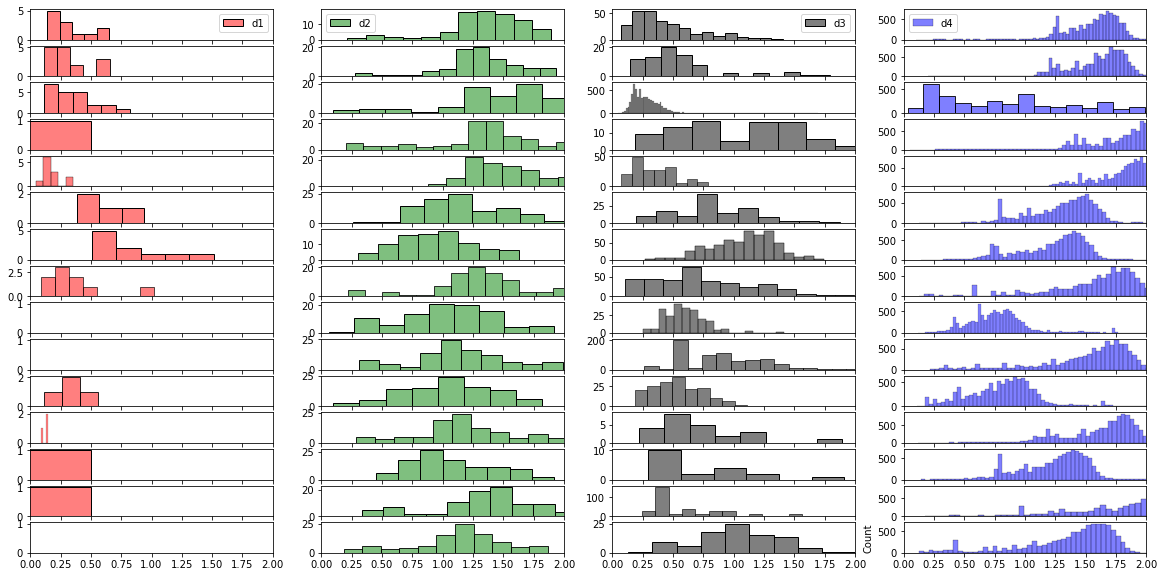

In [26]:
cellmodel.plot_distance(sencell_dict,nonsencell_dict,emb_pos=2)

In [27]:
1-

SyntaxError: invalid syntax (2847093696.py, line 1)

In [ ]:
# 优化完之后，要把sampled_graph里面cell的embedding全部替换
# 然后基于updated graph，先划定老化基因，然后再划定老化细胞

In [ ]:
sampled_graph=sampled_graph.to('cpu')
sencell_dict,nonsencell_dict
feature=sampled_graph.x
for key,value in sencell_dict.items():
    feature[key]=value[2].detach().cpu()

for key,value in nonsencell_dict.items():
    feature[key]=value[2].detach().cpu()
sampled_graph.x=feature

In [ ]:
def identify_sengene_sencell_marker_graph(sampled_graph,model,cell_clusters,
                                  big_graph_index_dict,
                                  sencell_dict,
                                  nonsencell_dict,
                                  ratio=0.1,plot=False):
    # 这个函数里面首先会先识别老化基因
    # 然后再识别老化细胞
    # cell_clusters: tensor
    
    # step 1: get embedding and attention
    model.eval()
    model.to(device)
    sampled_graph.to(device)
    # edge_att: nx1
    # 注意这里的的edge是双向边
    # 对应的edge_att也是双向边的权重，而且二者不一定相同
    # 这里edge表示(source,target)
    # 所以一个target节点与所有source节点之间边attention之和为1
    # 所以这里找老化细胞考虑的cell score是以gene为target, cell score是其出现过的所有attention之和
    z,(edge,edge_att)=model.encoder.get_att(sampled_graph)
    att=edge_att.T[0].detach().cpu()
    z=z.detach().cpu()
    
    # step 2: 识别老化基因
    sencell_indexs=list(sencell_dict.keys())
    nonsencell_indexs=list(nonsencell_dict.keys())
    
    # 为每一个sencell所连接的基因赋予attention权重
    # 这里面存储与sencell所相连的gene（key）和attention权重（value）
    sen_gene_dict={}
    for sencell_index in sencell_indexs:
        candidate_genes=edge[0][edge[1]==sencell_index]
        candidate_genes_atts=att[edge[1]==sencell_index]
        for candidate_gene,candidate_genes_att in zip(candidate_genes,candidate_genes_atts):
            sen_gene_dict[candidate_gene]=sen_gene_dict.get(candidate_gene,0)+candidate_genes_att
    
    # 依据att从小到大
    sen_gene_ls=[k for k, v in sorted(sen_gene_dict.items(), key=lambda item: item[1])]
    # 因为这个图上的基因全是老化基因的marker，所以这里只能删除，不能增加
    # 先看一下这里的marker改变如何
    print('rechoice sengene num:',len(sen_gene_ls))
    print(sen_gene_ls)
    
    # step 3: 选出来老化基因之后，重新选老化细胞和非老化细胞
    
    return
            
    
    
    # step 2: identify sencell and nonsencell
    cell_index=torch.arange(len(sampled_graph.y))[torch.bitwise_not(sampled_graph.y)]
    cell_att=[]
    for cell in cell_index:
        cell_att.append(att[edge[0]==cell].sum())
    cell_att=torch.tensor(cell_att)
    # 从大到小
    sorted_index=torch.argsort(cell_att,descending=True)
    sencell_num=100
    if plot:
        sns.displot(cell_att)
        plt.ylim(0,20)
        sns.displot(cell_att[sorted_index][:sencell_num])
    print('sencell_num:',sencell_num)
    
    sencell_index=cell_index[sorted_index][:sencell_num]
    nonsencell_index=cell_index[sorted_index][sencell_num:]

    sencell_cluster=cell_clusters[sencell_index]
    nonsencell_cluster=cell_clusters[nonsencell_index]
    
    # step 3: output
    # 最后的输出结果，存储[emb，cluster, new_emb=0, big_graph_index]信息
    # new_emb用来占位，big_graph_index是cell节点在大图上的index
    sencell_dict={}
    nonsencell_dict={}
    
    for index,cluster in zip(sencell_index,sencell_cluster):
        # index是tensor
        i=int(index)
        sencell_dict[i]=[z[i],int(cluster),0,big_graph_index_dict[i]]
    for index,cluster in zip(nonsencell_index,nonsencell_cluster):
        i=int(index)
        nonsencell_dict[i]=[z[i],int(cluster),0,big_graph_index_dict[i]]
    
    return sencell_dict,nonsencell_dict

In [41]:
a={1:1,2:2,3:3,4:4}
a.pop(1)

1

In [42]:
a

{2: 2, 3: 3, 4: 4}

In [ ]:
cellmodel=EncoderLinear().to(device)

prototype_emb=cellmodel.plot_distance(sencell_dict,nonsencell_dict,emb_pos=0)

In [ ]:
# 再画一个UMAP图

In [ ]:




def sub_sampling_sen(graph,cluster_index, num_sen=5,num_nonsen=5):
    ls1=np.random.choice(range(3260,3622),num_sen,replace=False)
    ls2=np.random.choice(range(3260),num_nonsen,replace=False)

    sub_gene_markers=torch.tensor(np.concatenate([ls1,ls2]))
    res=k_hop_subgraph(sub_gene_markers, 1, graph.edge_index,relabel_nodes=True)
    
    cell_index=res[0][num_sen+num_nonsen:].detach().cpu()
    clusters=cluster_index[cell_index-3622]
    # y里面的指定了前10个embedding中哪些是老化基因的embedding
    # y里面10以后指定了细胞的cluster标签
    lables=torch.cat([res[2]<5,clusters])
    sampled_graph = Data(x=graph.x[res[0]], edge_index=res[1],y=lables)
    return sampled_graph
    
    
def get_cell_index(edge,edge_att,gene_marker,ratio=0.1):
    # 根据attention 的到cell_index
    # 每个cell 都会有一个打分，打分是attention权重之和
    cell_score={}
    for j,i in enumerate(gene_marker):
        atts=edge_att[edge[0]==i].T[0].cpu().detach().numpy()
        # attention 分布
        # sns.histplot(atts.detach().cpu(),ax=ax[j])
        cell_index=edge[1][edge[0]==i].cpu().detach().numpy()
        for att,cell in zip(atts,cell_index):
            cell_score[cell]=cell_score.get(cell,0)+att
    
    # 对应的att从小到大   
    sorted_cell_index=[k for k, v in sorted(cell_score.items(), key=lambda item: item[1])]
    # 把这里面最大的10%的cell作为sen cell
    sencell_number=int(len(sorted_cell_index)*ratio)
    cell_index=sorted_cell_index[-sencell_number:]
    return cell_index
    

def get_cell_index_marker(sampled_graph,edge,edge_att,sencell_ratio=0.1):
    # 基于attention的到sencell
    sen_gene_index=torch.arange(10)[sampled_graph.y[:10]==1]
    non_sen_gene_index=torch.arange(10)[sampled_graph.y[:10]==0]
    # f, ax = plt.subplots(1,5,figsize=(10,2))
    print(sen_gene_index)
    sen_cell_index=get_cell_index(edge,edge_att,sen_gene_index)
    non_sen_cell_index=get_cell_index(edge,edge_att,non_sen_gene_index)
    
    print('sen cell number',len(sen_cell_index))
    print('non sen cell number',len(non_sen_cell_index))
    intersections=set(sen_cell_index).intersection(non_sen_cell_index)
    print('intersections:',len(intersections))
    
    return sen_cell_index,non_sen_cell_index
    
    
def get_cell_index_random(sampled_graph,edge,edge_att,sencell_ratio=0.1):
    # 基于attention的到sencell
    sen_gene_index=torch.arange(10)[sampled_graph.y[:10]==1]
    non_sen_gene_index=torch.arange(10)[sampled_graph.y[:10]==0]
    # f, ax = plt.subplots(1,5,figsize=(10,2))
    print(sen_gene_index)
    sen_cell_index=get_cell_index(edge,edge_att,sen_gene_index)
    non_sen_cell_index=get_cell_index(edge,edge_att,non_sen_gene_index)
    
    print('sen cell number',len(sen_cell_index))
    print('non sen cell number',len(non_sen_cell_index))
    intersections=set(sen_cell_index).intersection(non_sen_cell_index)
    print('intersections:',len(intersections))
    
    return sen_cell_index,non_sen_cell_index



def get_nonsencell_index(sencell_index,sampled_graph):
    cell_indexs=set(list(range(10,sampled_graph.x.shape[0])))
    sencell_indexs=set(sencell_index)
    nonsencell_indexs=cell_indexs-sencell_indexs
    
    return list(nonsencell_indexs)


def sub_sampling_sen1(graph,cluster_index, num_sen=5,num_nonsen=5):
    # 控制cell这边的数量
    ls1=np.random.choice(range(3260,3622),num_sen,replace=False)
    ls2=np.random.choice(range(3260),num_nonsen,replace=False)

    sub_gene_markers=torch.tensor(np.concatenate([ls1,ls2]))
    res=k_hop_subgraph(sub_gene_markers, 1, graph.edge_index,relabel_nodes=True)
    print('sampling cell number',len(res[0])-10)
    cell_index=res[0][num_sen+num_nonsen:].detach().cpu()
    clusters=cluster_index[cell_index-3622]
    # y里面的指定了前10个embedding中哪些是老化基因的embedding
    # y里面10以后指定了细胞的cluster标签
    lables=torch.cat([res[2]<5,clusters])
    sampled_graph = Data(x=graph.x[res[0]], edge_index=res[1],y=lables)
    
    # 对采样得到的子图进行剪枝
    
    
    return sampled_graph

    
# num_subgraphs=100
# jobs=[]
# for _ in range(num_subgraphs):
#     sampled_graph=sub_sampling_sen1(graph,cluster_index)
    

#     z,(edge,edge_att)=model.encoder.get_att(sampled_graph)
# #     sampled_graph=sampled_graph.to('cpu')
    
    
#     print(edge_att.shape)
#     print(sampled_graph.edge_index)
#     sampled_graph.x=z.detach()

#     # 这个index里面0-9是基因的
#     sencell_index=get_sencell_index(sampled_graph,edge,edge_att)
#     # 这个index里面0-9是基因的
#     nonsencell_index=get_nonsencell_index(sencell_index,sampled_graph)
    
#     break
#     jobs.append(sampled_graph)


def sub_sampling_by_marker_old(graph,cluster_index,marker_index):
    num_sen=len(marker_index)
    print('sen gene number',num_sen)
    num_nonsen=num_sen
    ls1=marker_index
    ls2=np.random.choice(range(3260),num_nonsen,replace=False)

    sub_gene_markers=torch.tensor(np.concatenate([ls1,ls2]))
    res=k_hop_subgraph(sub_gene_markers, 1, graph.edge_index,relabel_nodes=True)
    # res[0]是子图所有节点在原图上的index
    # new_index是新图节点index，和res[0]是一一对应的
    new_index=torch.arange(len(res[0]))
    # res[2]是sub_gene_markers在采样到的子图中的index
    # 这两个index表示新图上哪些节点是sen gene，哪些是non sen gene
    new_sen_gene_index=res[2][:num_sen]
    new_non_sen_gene_index=res[2][-num_nonsen:]
    print('rs[2]',res[2])
    # 新图上cell index
    new_cell_index=list(set(range(len(res[0])))-set(res[2].cpu().tolist()))
    print('cell index',res[0][new_cell_index])
    
    
    return 
    
    # cell_index是graph上的index
    print(res[0][:num_sen+num_nonsen])
    cell_index=res[0][num_sen+num_nonsen:].detach().cpu()
    clusters=cluster_index[cell_index-3622]
    
    # 除此之外的所有index便是cell的index
    print(res[0][non_sen_gene_index])
    print(res[0][sen_gene_index])
    # y里面的指定了前num_sen+num_nonsen个embedding中哪些是老化基因的embedding
    # y里面10以后指定了细胞的cluster标签
    lables=torch.cat([res[2]<num_sen,clusters])
    sampled_graph = Data(x=graph.x[res[0]], edge_index=res[1],y=lables)
    return sampled_graph


    

In [ ]:
cellmodel=torch.load('./cellmodel.pt')

In [ ]:
'''
model.eval()
cellmodel.eval()
jobs=torch.load('./jobs.file')
for sampled_graph in jobs:
    z,(edge,edge_att)=model.encoder.get_att(sampled_graph)
    sampled_graph.x=z.detach()

    # 这个index里面0-9是基因的
    sencell_index=get_sencell_index(sampled_graph,edge,edge_att)
    # 这个index里面0-9是基因的
    nonsencell_index=get_nonsencell_index(sencell_index,sampled_graph)
    sencell_index=torch.tensor(sencell_index).to(device)
    nonsencell_index=torch.tensor(nonsencell_index).to(device)

    sampled_graph = sampled_graph.to(device)
    outs = cellmodel(sampled_graph.x[10:])
    plot=True
    cellmodel.loss(outs,sampled_graph,sencell_index,nonsencell_index,plot)
    break
'''

In [ ]:
# for name, parms in cellmodel.named_parameters():
#     print('-->name:', name)
#     print('-->para:', parms)
#     print('-->grad_requirs:',parms.requires_grad)
#     print('-->grad_value:',parms.grad)

In [ ]:
# 模型训练完成后，将整个图输入进去
model.eval()
cellmodel.eval()

def samlping_sengraph(graph):
    labels=torch.cat([torch.zeros(3260),torch.ones(3622-3260),cluster_index.cpu()])
    sampled_graph=Data(x=graph.x,
                       edge_index=graph.edge_index,
                       y=labels)
    return sampled_graph

def get_sencell_index1(sampled_graph,edge,edge_att,split=3622):
    # 基于attention的到sencell
    sen_gene_index=torch.arange(split)[sampled_graph.y[:split]]

    # f, ax = plt.subplots(1,5,figsize=(10,2))

    res=[]
    for j,i in enumerate(sen_gene_index):
        atts=edge_att[edge[0]==i]
        # attention 分布
        # sns.histplot(atts.detach().cpu(),ax=ax[j])
        cell_index=edge[1][edge[0]==i]
        # 保留attention>=0.5的cell
        cell_index=cell_index[atts.T[0]>=0.1].detach().cpu()
        res.append(cell_index)

    results=list(set(torch.cat(res).tolist()))
    # print('sencell num: ',len(results))
    return results

def get_nonsencell_index1(sencell_index,sampled_graph,split=3622):
    cell_indexs=set(list(range(split,sampled_graph.x.shape[0])))
    sencell_indexs=set(sencell_index)
    nonsencell_indexs=cell_indexs-sencell_indexs
    
    return list(nonsencell_indexs)


sampled_graph=samlping_sengraph(graph)
print(sampled_graph)
z,(edge,edge_att)=model.encoder.get_att(sampled_graph)
sampled_graph.x=z.detach()
# 这个index里面0-9是基因的
sencell_index=get_sencell_index1(sampled_graph,edge,edge_att)
# 这个index里面0-9是基因的
nonsencell_index=get_nonsencell_index1(sencell_index, sampled_graph)
print(sencell_index,nonsencell_index)
sencell_index=torch.tensor(sencell_index).to(device)
nonsencell_index=torch.tensor(nonsencell_index).to(device)

sampled_graph = sampled_graph.to(device)

plot=False
split=3622
outs = cellmodel(sampled_graph.x[split:])
# loss=cellmodel.loss(outs,sampled_graph,sencell_index,nonsencell_index,plot)


In [ ]:
1-

In [ ]:
new_graph = Data(x=torch.cat([x[:3622],outs.detach()]), edge_index=edge_index)
new_graph=new_graph.to(device)

new_graph.x

In [ ]:
outs.shape

In [ ]:
torch.save(new_graph,'./new_graph.tensor')

In [ ]:
1-

In [ ]:
model(new_graph,split=3622)

In [ ]:
1-

In [ ]:
class Plots():
    def getClusters(self,sampled_graph,sencell_index,nonsencell_index):
        # 计算cluster_index和sencell_index的映射表
        clusters=sampled_graph.y[sencell_index]        
        cluster_set=set(clusters.cpu().tolist())
        all_clusters={}
        for i in cluster_set:
            all_clusters[i]=sencell_index[clusters==i]
        sen_cluster_index=cluster_set
        
        # 还要计算cluster_index和nonsencell_index大的映射表
        clusters=sampled_graph.y[nonsencell_index]
        cluster_set=set(clusters.cpu().tolist())
        for i in cluster_set:
            # 注意到簇的数量不要大于100！
            # 非老化细胞的簇减去100
            all_clusters[i-100]=nonsencell_index[clusters==i]
            
        nonsen_cluster_index=cluster_set
        # all_cluster里面value的index的0-10是基因的
        # 考虑到有的簇里面并不是老化细胞和非老化细胞都有，所以这里返回cluster的index用于后面
        return all_clusters,(sen_cluster_index,nonsen_cluster_index)
    
    def getPrototypeEmbedding(self,outs,all_clusters,split=3622-3260):
        prototype={}
        for i,j in all_clusters.items():
            # 这里要减10
            prototype[i]=torch.mean(outs[j-split],0)
        
        return prototype
        
    def calculateDistanceMatrix(self,prototype,outs):
        # 计算每个cell和prototype之间的距离
        # 得到n*K的矩阵
        results=[]
        # 存储cluster的名称
        cluster_names=[]
        for i,j in prototype.items():
            distances=torch.cdist(outs, j.view(1,-1), p=2)
            results.append(distances)
            cluster_names.append(i)
        
        distance_matrix=torch.cat(results,1)
        
        # Standardization
        mean=torch.mean(distance_matrix)
        std=torch.std(distance_matrix)
        distance_matrix=(distance_matrix-mean)/std        
        # plot
#         sns.displot(distance_matrix.view(-1).detach().cpu())
        # print(distance_matrix)
        return distance_matrix, cluster_names
    
    def getDifferentDistance(self, all_clusters, distance_matrix, indexs, cluster_names,split=3622-3260):
        sen_cluster_index,nonsen_cluster_index=indexs
        distances=[]
        for cluster in sen_cluster_index:
            col_index=cluster_names.index(cluster)
            # d1老化细胞簇内细胞和簇心的距离
            # 这里要减10
            d1=distance_matrix[all_clusters[cluster]-split,col_index]
            # d2是这一簇的老化细胞的簇心和其它簇的老化细胞之间的距离
            d2=[]
            # 这里考虑的是其它有老化细胞的簇
            for other_cluster in sen_cluster_index:
                if cluster!=other_cluster:
                    # 这里要减10
                    d2.append(distance_matrix[all_clusters[other_cluster]-split,col_index])
            # 可能存在只有一个老化细胞的情况
            if len(d2)==0:
                d2=torch.tensor([]).to(device)
            else:
                d2=torch.cat(d2)  
            # d3是这一簇内部老化细胞簇心和非老化细胞之间的距离
            # 可能有一簇全是老化细胞
            if cluster-100 in all_clusters:
                d3=distance_matrix[all_clusters[cluster-100]-split,col_index]
            else:
                d3=torch.tensor([]).to(device)
            # d4是老化细胞簇心和其它簇非老化细胞之间的距离
            d4=[]
            # 这里考虑的是其它有非老化细胞的簇
            for other_cluster in nonsen_cluster_index:
                if cluster!=other_cluster:
                    # 这里要减10
                    d4.append(distance_matrix[all_clusters[other_cluster-100]-split,col_index])
            d4=torch.cat(d4)
            distances.append([d1,d2,d3,d4])
        
        # print(distances)
        return distances
    
    def plotdistance(self,distances):
        d1,d2,d3,d4=distances
        plt.figure()
        sns.histplot(d1.detach().cpu(),alpha=0.5,color='red',label='d1')
        sns.histplot(d2.detach().cpu(),alpha=0.5,color='green',label='d2')
        sns.histplot(d3.detach().cpu(),alpha=0.5,color='black',label='d3')
#         sns.histplot(d4.detach().cpu(),alpha=0.5,color='blue',label='d4')
        plt.ylim([0, 100])
        plt.legend()
    
    def getMLDloss(self,distances,plot=False):
        if plot:
            for i in distances:
                self.plotdistance(i)

        
        results=0
        
        
        return results/len(distances)
    
    def prototypeLoss(self,distances):
        results=0
        for cluster_distance in distances:
            results+=cluster_distance[0].square().sum().sqrt()
            
        return results/len(distances)
    
    def loss(self, outs, graph, sencell_index,nonsencell_index,plot=False):
        all_clusters,indexs=self.getClusters(graph, sencell_index,nonsencell_index)
        # print("cluster index (sen and nonsen): ",indexs)
        # 存储prototype的embedding
        prototype=self.getPrototypeEmbedding(outs,all_clusters)
#         print(prototype)
        distance_matrix, cluster_names=self.calculateDistanceMatrix(prototype,outs)
        # print("distance_matrix.shape: ",distance_matrix.shape)
        # print("cluster_names: ",cluster_names)
        # sns.heatmap(distance_matrix.detach().cpu().numpy(),cmap='Greys')
        distances=self.getDifferentDistance(all_clusters,distance_matrix,indexs,cluster_names)
        loss=self.getMLDloss(distances,plot)
        
        return loss

plots=Plots()

plots.loss(outs,sampled_graph,sencell_index,nonsencell_index,True)


In [ ]:
outs.shape

In [ ]:
x[:3622].shape

## 使用DeepMAPS找celltype并对embedding进行变换

In [ ]:
# from gpu_mem_track import MemTracker
# gpu_tracker = MemTracker()         # define a GPU tracker

In [ ]:
from sklearn.neighbors import kneighbors_graph

A = kneighbors_graph(cell_metrix, 30, mode='connectivity', include_self=True)
adj=A.toarray()
adj.shape

In [ ]:
G = nx.from_numpy_matrix(adj)

partition = community_louvain.best_partition(G)

In [ ]:
max(partition.values())

In [ ]:
cluster_index=np.array(list(partition.values()))
cluster_index

In [ ]:
def sub_sampling_sen(graph,num_sen=5,num_nonsen=5):
    ls1=np.random.choice(range(3260,3622),num_sen,replace=False)
    ls2=np.random.choice(range(3260),num_nonsen,replace=False)

    sub_gene_markers=torch.tensor(np.concatenate([ls1,ls2]))
    res=k_hop_subgraph(sub_gene_markers, 1, graph.edge_index,relabel_nodes=True)
    
    cell_index=res[0][num_sen+num_nonsen:].detach().cpu()
    clusters=torch.tensor(cluster_index[cell_index-3622])
    # y里面的指定了前10个embedding中哪些是老化基因的embedding
    # y里面10以后指定了细胞的cluster标签
    lables=torch.cat([res[2]<5,clusters])
    sampled_graph = Data(x=graph.x[res[0]], edge_index=res[1],y=lables)
    return sampled_graph
    
    
num_subgraphs=100
jobs=[]
for _ in range(num_subgraphs):
    sampled_graph=sub_sampling_sen(graph)
    jobs.append(sampled_graph)

In [ ]:
"""
# 下面是对单个采样图的处理
model.eval()
z,(edge,edge_att)=model.encoder.get_att(sampled_graph)

gene_embedding=z[:10]
cell_embedding=z[10:].detach().cpu()

embedding = reducer.fit_transform(cell_embedding)
print(embedding.shape)
all_clusters=set(sampled_graph.y[10:].cpu().tolist())
print(all_clusters)
for cluster in all_clusters:  
    mask=(sampled_graph.y[10:]==cluster).cpu()
    plt.scatter(embedding[mask,0],
                embedding[mask,1],alpha=0.5,s=5)
    
# 这个index里面0-9是基因的
sencell_index=get_sencell_index(sampled_graph,edge,edge_att)
# 这个index里面0-9是基因的
nonsencell_index=get_nonsencell_index(sencell_index,sampled_graph)

cell_index=np.array(sencell_index)-10
plt.scatter(embedding[:,0],embedding[:,1],alpha=0.5,s=5)
plt.scatter(embedding[cell_index,0],embedding[cell_index,1],alpha=0.5,s=5,c='red')

sencell_index=torch.tensor(sencell_index).to(device)
nonsencell_index=torch.tensor(nonsencell_index).to(device)

# device='cpu'
# sencell_index=torch.tensor(sencell_index).to(device)
# nonsencell_index=torch.tensor(nonsencell_index).to(device)
"""

In [ ]:
# 训练完之后，查看不同的distance
cellmodel.eval()
model.eval()

# num_subgraphs=5
# jobs=[]
# for _ in range(num_subgraphs):
#     sampled_graph=sub_sampling_sen(graph)
#     jobs.append(sampled_graph)

for sampled_graph in jobs:
#     z,(edge,edge_att)=model.encoder.get_att(sampled_graph)
#     sampled_graph.x=z.detach()
    
    # 这个index里面0-9是基因的
    sencell_index=get_sencell_index(sampled_graph,edge,edge_att)
    # 这个index里面0-9是基因的
    nonsencell_index=get_nonsencell_index(sencell_index,sampled_graph)
    sencell_index=torch.tensor(sencell_index).to(device)
    nonsencell_index=torch.tensor(nonsencell_index).to(device)
    
    sampled_graph = sampled_graph.to(device)


    outs = cellmodel(sampled_graph.x[10:])
    loss=cellmodel.loss(outs,sampled_graph,sencell_index,nonsencell_index,plot=True)

    break

In [ ]:
x.shape

In [ ]:
torch.cat([x[:3622],])

In [ ]:
outs.shape

In [ ]:
sampled_graph.x[10:].shape

In [ ]:
torch.square()

In [ ]:
torch.tensor([1,2,3]).sum().sqrt()

In [ ]:
sencell_index

In [ ]:
a=torch.tensor([[1,2,3],[2,3,2]],dtype=torch.float)
b=torch.tensor([2,2,2],dtype=torch.float)

torch.cdist(a, b, p=2)

In [ ]:
b.view(1,-1)

In [ ]:
edge,edge_att=model.encoder.get_att(graph)[1]

In [ ]:
max(edge_att),min(edge_att)

In [ ]:
edge_att

In [ ]:
from utils import build_graph

graph=build_graph(gene_cell,gene_embed,cell_embed)

In [ ]:
class ARGS():
    epoch=30
    data_path='/fs/ess/scratch/PCON0022/wxy/deepmaps_xy/fs/ess/scratch/PCON0022/xy/RNA_ATAC/data/GAS/cell_line.txt'
    data_name='cell_line_new_sampling'
    n_hid=49
    n_heads=7
    n_layers=2
    lr=0.5
    n_batch=50
    batch_size=110

    # default
    result_dir='/users/PCON0022/haocheng/DeepMAPS/myMAPS/results/'
    reduction='AE'
    in_dim=256
    dropout=0
    sample_depth=4
    sample_width=8
    layer_type='hgt'
    loss='kl'
    factor=0.5
    patience=5
    rf='0.0'
    cuda=-1
    optimizer='adamw'
    
    cell_rate=0.8
    gene_rate=0.3
    rep='T'


args = ARGS()

In [ ]:
from sub_sample1 import sub_sample_sen


jobs = []
cell_num=int((gene_cell.shape[1]*args.cell_rate)/args.n_batch)
gene_num=int((gene_cell.shape[0]*args.gene_rate)/args.n_batch)
print(f'cell_num: {cell_num}, gene_num: {gene_num}')
for _ in range(100):
    p = sub_sample_sen(graph,
                    gene_cell,
                    cell_num,
                    gene_num,
                    gene_cell.shape[0],
                    gene_cell.shape[1])
#     if set(p[-1]['gene']) & set(range(3259,3640)):
#         jobs.append(p)
    jobs.append(p)
print("sampling end!")

In [ ]:
# debuginfoStr('Cell Graph constructed and pruned')

gnn = GNN(conv_name=args.layer_type, in_dim=gene_embed.shape[1],
          n_hid=args.n_hid, n_heads=args.n_heads, n_layers=args.n_layers, dropout=args.dropout,
          num_types=2, num_relations=2, use_RTE=False).to(device)


# default: adamw
if args.optimizer == 'adamw':
    optimizer = torch.optim.AdamW(gnn.parameters(), lr=args.lr)
elif args.optimizer == 'adam':
    optimizer = torch.optim.Adam(gnn.parameters(), lr=args.lr)
elif args.optimizer == 'sgd':
    optimizer = torch.optim.SGD(gnn.parameters(), lr=args.lr)
elif args.optimizer == 'adagrad':
    optimizer = torch.optim.Adagrad(gnn.parameters(), lr=args.lr)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', factor=args.factor, patience=args.patience, verbose=True)

gnn.train()
for epoch in np.arange(args.epoch):
    L = 0
    for job in jobs:
        feature,time,edge_list,indxs = job
        node_dict = {}
        node_feature = []
        node_type = []
        node_time = []
        edge_index = []
        edge_type = []
        edge_time = []

        node_num = 0
        types = graph.get_types()   # ['gene','cell']
        for t in types:
            #print("t in types "+str(t)+"\n")
            node_dict[t] = [node_num, len(node_dict)]
            node_num += len(feature[t])
            if args.reduction == 'raw':
                node_feature.append([])
        # node_dict: {'gene':[0,0],'cell':[134,1]}
        for t in types:
            t_i = node_dict[t][1]
            #print("feature t:\n")
            #print("t_i="+str(t_i)+" t="+str(t)+"\n")
            # print(feature[t].shape)
            if args.reduction != 'raw':
                node_feature += list(feature[t])
            else:
                node_feature[t_i] = torch.tensor(
                    feature[t], dtype=torch.float32).to(device)

            node_time += list(time[t])
            node_type += [node_dict[t][1] for _ in range(len(feature[t]))]
        # node_type存放节点类型
        edge_dict = {e[2]: i for i, e in enumerate(graph.get_meta_graph())}
        edge_dict['self'] = len(edge_dict)
        # {'g_c': 0, 'rev_g_c': 1 ,'self': 2}
        for target_type in edge_list:
            for source_type in edge_list[target_type]:
                for relation_type in edge_list[target_type][source_type]:
                    for ii, (ti, si) in enumerate(edge_list[target_type][source_type][relation_type]):
                        tid, sid = ti + \
                            node_dict[target_type][0], si + \
                            node_dict[source_type][0]
                        edge_index += [[sid, tid]]
                        edge_type += [edge_dict[relation_type]]

                        # Our time ranges from 1900 - 2020, largest span is 120.
                        # edge_time += [node_time[tid] - node_time[sid] + 120]
                        edge_time += [120]

        if (args.reduction != 'raw'):
            node_feature = torch.stack(node_feature)
            node_feature = torch.tensor(node_feature, dtype=torch.float32)
            node_feature = node_feature.to(device)

        #node_feature = torch.trunc(node_feature*10000)/10000
        node_type = torch.LongTensor(node_type)
        edge_time = torch.LongTensor(edge_time)
        edge_index = torch.LongTensor(edge_index).t()
        edge_type = torch.LongTensor(edge_type)
        if (args.reduction == 'raw'):
            node_rep, node_decoded_embedding = gnn.forward(node_feature, 
                                                           node_type.to(device),
                                                           edge_time.to(device),
                                                           edge_index.to(device),
                                                           edge_type.to(device))
        else:
            node_rep = gnn.forward(node_feature, 
                                   node_type.to(device),
                                   edge_time.to(device),
                                   edge_index.to(device),
                                   edge_type.to(device))

        if args.rep == 'T':
            node_rep = torch.trunc(node_rep*10000000000)/10000000000
            if args.reduction == 'raw':
                for t in types:
                    t_i = node_dict[t][1]
                    # print("t_i="+str(t_i))
                    node_decoded_embedding[t_i] = torch.trunc(
                        node_decoded_embedding[t_i]*10000000000)/10000000000


        gene_matrix = node_rep[node_type == 0, ]
        cell_matrix = node_rep[node_type == 1, ]

        regularization_loss = 0
        for param in gnn.parameters():
            regularization_loss += torch.sum(torch.pow(param, 2))
        if (args.loss == "kl"):
            decoder = torch.mm(gene_matrix, cell_matrix.t())
            adj = gene_cell[indxs['gene'], ]
            adj = adj[:, indxs['cell']]
            adj = torch.tensor(adj, dtype=torch.float32).to(device)
            if args.reduction == 'raw':
                if epoch % 2 == 0:
                    loss = F.kl_div(decoder.softmax(
                        dim=-1).log(), adj.softmax(dim=-1), reduction='sum')+args.rf*regularization_loss
                else:
                    loss = nn.MSELoss()(
                        node_feature[0], node_decoded_embedding[0])+args.rf*regularization_loss
                    for t_i in range(1, len(types)):
                        loss += nn.MSELoss()(node_feature[t_i],
                                             node_decoded_embedding[t_i])
            else:
                loss = F.kl_div(decoder.softmax(dim=-1).log(),
                                adj.softmax(dim=-1), reduction='sum')

        if (args.loss == "cross"):
            # negative_sampling not defined
            print("negative_sampling not defined!")
            exit()
            pass

        L += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step(L/(int(gene_cell.shape[0])))
    print('Epoch :', epoch+1, '|', 'train_loss:%.12f' %
          (L/(int(gene_cell.shape[0]))/args.n_batch))


state = {'model': gnn.state_dict(), 'optimizer': scheduler.state_dict(),
         'epoch': epoch}


model_dir='./'
file0='f1'
torch.save(state, model_dir+file0)
# debuginfoStr('Graph Autoencoder training finished')




In [ ]:
from utils import build_data

In [ ]:
# debuginfoStr('load training model')
state = torch.load(model_dir+file0, map_location=lambda storage, loc: storage)
device = torch.device("cpu")


gnn = GNN(conv_name=args.layer_type, in_dim=gene_embed.shape[1], n_hid=args.n_hid, n_heads=args.n_heads, n_layers=args.n_layers, dropout=args.dropout,
          num_types=2, num_relations=2, use_RTE=False).to(device)



# model.eval()
if (gene_cell.shape[1]>10000):

    if (gene_cell.shape[0]>10000):
        ba = 500
    else:
        ba = gene_cell.shape[0]
else:
    if (gene_cell.shape[0]>10000):
        ba = 5000
    else:
        ba = gene_cell.shape[0]

gnn.load_state_dict(state['model'])
g_embedding = []
gene_name = []
cell_name = []
attention = []

with torch.no_grad():
    for i in range(0, gene_cell.shape[0], ba):
        adj = gene_cell[i:(i+ba), :]  
        x,node_type, edge_time, edge_index,edge_type=build_data(adj,gene_embed[i:(ba+i), :],cell_embed)
        if args.reduction != 'raw':
            node_rep = gnn.forward((torch.cat((x['gene'], x['cell']), 0)).to(device), 
            node_type.to(device),edge_time.to(device),
            edge_index.to(device), edge_type.to(device))
        else:
            node_rep, _ = gnn.forward([x['gene'].to(device), x['cell'].to(device)], 
                                       node_type.to(device),edge_time.to(device), 
                                       edge_index.to(device), edge_type.to(device))

        gene_name = gene_name + list(np.array(edge_index[0]+i))
        cell_name = cell_name + list(np.array(edge_index[1]-adj.shape[0]))
        attention.append(gnn.att)
        gene_matrix = node_rep[node_type == 0, ]
        cell_matrix = node_rep[node_type == 1, ]
        g_embedding.append(gene_matrix)

if gene_cell.shape[0] % ba == 0:
    gene_matrix = np.vstack(g_embedding[0:int(gene_cell.shape[0]/ba)])
    attention = np.vstack(attention[0:int(gene_cell.shape[0]/ba)])
else:
    final_tensor = np.vstack(g_embedding[0:int(gene_cell.shape[0]/ba)])
    gene_matrix = np.concatenate((final_tensor, gene_matrix), 0)
    final_attention = np.vstack(attention[0:int(gene_cell.shape[0]/ba)])
    attention = np.concatenate((final_attention, gnn.att), 0)
cell_matrix = cell_matrix.detach().numpy()
# np.savetxt(gene_dir+file0, gene_matrix, delimiter=' ')
# np.savetxt(cell_dir+file0, cell_matrix, delimiter=' ')

In [ ]:
cell_matrix.shape,gene_matrix.shape

In [ ]:
embedding = reducer.fit_transform(cell_matrix)
print(embedding.shape)
plt.scatter(embedding[:,0],embedding[:,1],alpha=0.5,s=5)

In [ ]:
import torch_geometric
from torch_geometric.data import HeteroData


In [ ]:


graph = HeteroData()

graph['gene'].x=gene_embed
graph['cell'].x=cell_embed

g_index,c_index = np.nonzero(gene_cell)
print('the number of edges:',len(g_index))
# 加上偏移量作为cell的节点标号
c_index += gene_cell.shape[0]
edges=torch.tensor([g_index, c_index], dtype=torch.float)

In [ ]:
graph = HeteroData()
graph['gene'].x=[[1],[2],[3]]
graph['cell'].x=[[4],[5],[6]]

graph['gene','express','cell'].edge_index=[[0,1],[0,2]]
graph['cell','express','gene'].edge_index=[[1,0],[2,0]]

In [ ]:
graph

In [ ]:
graph['gene','express','cell']

In [ ]:
graph.num_nodes=6

In [ ]:
graph

In [ ]:
import itertools
import matplotlib.pyplot as plt
import networkx as nx

subset_sizes = [5, 6]
subset_color = [
    "gold",
    "violet",
    "violet",
    "violet",
    "violet",
    "limegreen",
    "limegreen",
    "darkorange",
]


def multilayered_graph(*subset_sizes):
    extents = nx.utils.pairwise(itertools.accumulate((0,) + subset_sizes))
    layers = [range(start, end) for start, end in extents]
    G = nx.Graph()
    for (i, layer) in enumerate(layers):
        G.add_nodes_from(layer, layer=i)
    for layer1, layer2 in nx.utils.pairwise(layers):
        G.add_edges_from(itertools.product(layer1, layer2))
    return G


G = multilayered_graph(*subset_sizes)
color = [subset_color[data["layer"]] for v, data in G.nodes(data=True)]
pos = nx.multipartite_layout(G, subset_key="layer")
plt.figure(figsize=(8, 8))
nx.draw(G, pos, node_color=color, with_labels=False)
plt.axis("equal")
plt.show()

In [ ]:
G.nodes(data=True)

In [ ]:
G = nx.Graph()

G.add_nodes_from(range(5), layer=0)
G.add_nodes_from(range(5,9), layer=1)
G.add_edges_from([[0,5],[2,8]])

color = [subset_color[data["layer"]] for v, data in G.nodes(data=True)]

pos = nx.multipartite_layout(G, subset_key="layer")
plt.figure(figsize=(8, 8))
nx.draw(G, pos, node_color=color, with_labels=True)

In [ ]:
from torch_geometric.datasets import OGB_MAG

dataset = OGB_MAG(root='./data', preprocess='metapath2vec')
data = dataset[0]

In [ ]:
data

In [ ]:
data.has_isolated_nodes()
data.has_self_loops()
data.is_undirected()

In [ ]:
from utils import build_graph,build_data
graph=build_graph(results,gene_embed,cell_embed)

In [ ]:
embedding = reducer.fit_transform(cell_matrix)
print(embedding.shape)
plt.scatter(embedding[:,0],embedding[:,1],alpha=0.5,s=5)

In [ ]:
attention.shape

In [ ]:
jobs[0]